# Mateusz Borowski, Hubert Bujakowski, Grzegorz Zbrzeżny

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import warnings
import xgboost
import shap
import itertools
import re

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from datetime import datetime
from collections import Counter

# warnings.filterwarnings("ignore")
sns.set()

c:\Users\boro\anaconda3\envs\wum\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
df = pd.read_csv('data/train.csv')
df = df[df['log_price'] > 0]
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [3]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=710)

In [4]:
def corr_direction_change(data, corr):
    df = data.select_dtypes(exclude=['object'])
    idx = 0
    for col in df:
        if corr[idx] < 0 :
            data[col] = -data[col]
        idx += 1

In [5]:
corr_train = list(train_df.corr()['log_price'])

corr_direction_change(train_df, corr_train)
corr_direction_change(test_df, corr_train)

In [6]:
X_train = train_df.drop(columns=['log_price'])
y_train = train_df['log_price']

X_test = test_df.drop(columns=['log_price'])
y_test = test_df['log_price']

In [7]:
numeric_cols = ['accommodates', 'bathrooms', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds', 'latitude', 'longitude']
onehot_cols = ['property_type', 'room_type', 'bed_type', 'city', 'cleaning_fee']
ordinal_cols = ['cancellation_policy']
binary_cols = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
date_cols = ['first_review', 'host_since', 'last_review']
percent_cols = ['host_response_rate']
amenities_cols = ['amenities']
# drop_cols = ['id', 'description', , 'name', 'neighbourhood', 'thumbnail_url', 'zipcode'] 

### Encodery

In [8]:
class BinaryEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = np.where(X_ == 't', 1, 0)
        return X_

In [9]:
class DaysSinceEncoder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = pd.DataFrame(X_) # in case X is a numpy array
        X_ = X_.apply(pd.to_datetime)
        delta = datetime.now() - X_
        days_since = delta.apply(lambda col: col.dt.days)
        days_since = days_since.fillna(-1)
        return days_since

In [10]:
class PercentToNumberEncoder(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X_ = X.copy()
        X_ = pd.DataFrame(X_) # in case X is a numpy array
        X_ = X_.apply(lambda col: col.str.rstrip('%'))
        X_ = X_.fillna(0)
        X_ = X_.astype(int)
        return X_

In [11]:
class AmenitiesEncoder(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        super().__init__()
        self.amenities_list = list()
    
    def fit(self, X, y=None):
        l = list(X.iloc[0])
        l = [[word.strip('[" ]') for word in row[1:-1].split(',')] for row in l]
        lst = list(itertools.chain.from_iterable(l))
        final = Counter(lst)
        final = final.most_common(35)
        self.amenities_list = [el for el, _ in final]
        return self

    def transform(self, X, y=None):
        
        def replacespaces(s):
            s = re.sub(r"[^\w\s]", '', s)
            s = re.sub(r"\s+", '-', s)
            return s
               

        tmp = pd.DataFrame()
        for el in self.amenities_list:
            tmp[el] = X['amenities'].str.contains(el).astype(int)
            
        cols = [replacespaces(col) for col in tmp.columns]
        tmp.columns = cols
        
        return tmp

    def get_feature_names(self):
        return self.amenities_list


In [12]:
numeric_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('scale', StandardScaler())
])

binary_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value='f')),
    ('encode', BinaryEncoder())
])

percent_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0)),
    ('encode', PercentToNumberEncoder())
])

column_transformer = ColumnTransformer(
    [('numeric', numeric_pipe, numeric_cols),
     ('onehot', OneHotEncoder(drop='if_binary', handle_unknown='ignore'), onehot_cols),
     ('ordinal', OrdinalEncoder(categories=[['flexible', 'moderate', 'strict', 'super_strict_30', 'super_strict_60']]), ordinal_cols),
     ('binary', binary_pipe, binary_cols),
     ('date', DaysSinceEncoder(), date_cols), # missing values are handled inside encoder
     ('precent', percent_pipe, percent_cols),
     ('amenities', AmenitiesEncoder(), amenities_cols)],
    remainder='drop'
)

In [13]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == sklearn.pipeline.Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == sklearn.pipeline.Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names) == 0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [14]:
X_train_ = pd.DataFrame(column_transformer.fit_transform(X_train))
X_test_ = pd.DataFrame(column_transformer.transform(X_test))

col_names = get_feature_names(column_transformer)
X_train_.columns = col_names
X_test_.columns = col_names

Transformer impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Transformer ordinal (type OrdinalEncoder) does not provide get_feature_names. Will return input column names if available
Transformer encode (type BinaryEncoder) does not provide get_feature_names. Will return input column names if available
Transformer date (type DaysSinceEncoder) does not provide get_feature_names. Will return input column names if available
Transformer encode (type PercentToNumberEncoder) does not provide get_feature_names. Will return input column names if available


## Podstawowy model na potrzeby feature selection

In [15]:
xgb = xgboost.XGBRegressor(eval_metric = "merror")
xgb.fit(X_train_, y_train)

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='merror', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
def print_metrics(y, y_hat):
    print(f"MSE: {mean_squared_error(y, y_hat)}")
    print(f"RMSE: {mean_squared_error(y, y_hat, squared=False)}")
    print(f"MAE: {mean_absolute_error(y, y_hat)}")

In [17]:
pred_train = xgb.predict(X_train_)
print_metrics(y_train, pred_train)

MSE: 0.10811476455446516
RMSE: 0.3288080968505264
MAE: 0.24104151064350013


In [18]:
pred_test = xgb.predict(X_test_)
print_metrics(y_test, pred_test)

MSE: 0.1492299017504208
RMSE: 0.3863028627261527
MAE: 0.2768254995794905


## Feature selection

In [19]:
def feature_selection(model, X_train):
    shap_values = shap.TreeExplainer(model).shap_values(X_train)
    shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=X_train.shape[1], show=False)
    plt.title("Feature importances based on shap value")
    plt.show()
    
    importances = []
    for i in range(X_train.shape[1]):
        col_sum = 0
        for j in range(X_train.shape[0]):
            col_sum += abs(shap_values[j][i])
        importances.append(col_sum/(X_train.shape[0] + 1))
    
    
    indices = []
    for i in range(X_train.shape[1]):
        if importances[i] > 0.01:
            indices.append(i)

    return X_train.columns[indices]

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


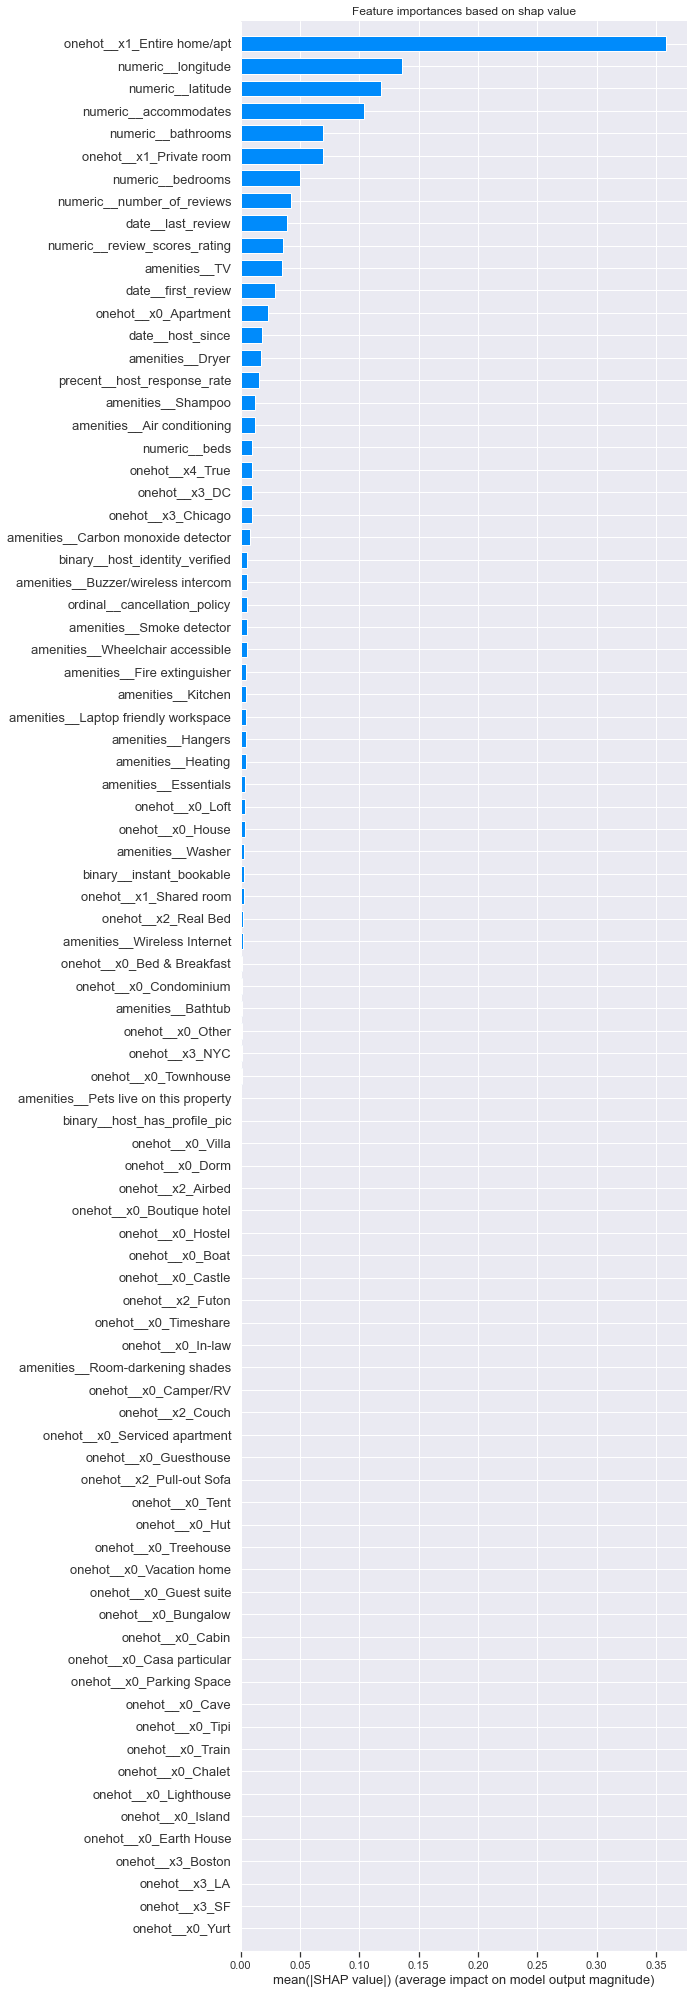

Index(['numeric__accommodates', 'numeric__bathrooms',
       'numeric__number_of_reviews', 'numeric__review_scores_rating',
       'numeric__bedrooms', 'numeric__latitude', 'numeric__longitude',
       'onehot__x0_Apartment', 'onehot__x1_Entire home/apt',
       'onehot__x1_Private room', 'date__first_review', 'date__host_since',
       'date__last_review', 'precent__host_response_rate', 'amenities__TV',
       'amenities__Air conditioning', 'amenities__Dryer',
       'amenities__Shampoo'],
      dtype='object')

In [20]:
selected_cols = feature_selection(xgb, X_train_)
selected_cols

In [21]:
X_train_ = X_train_[selected_cols]
X_test_ = X_test_[selected_cols]

## Hiperparametryzacja

In [22]:
params = {"max_depth" : [i for i in range(4, 15)],
          "subsample" : [i/10.0 for i in range(6,10)],
          "eta" : [i/100 for i in range(2, 31, 3)],
          "alpha" : [i/10 for i in range(0, 4)],
          "gamma" : [i for i in range(0, 10)],
          "min_child_weight" : [i for i in range(0, 8)],
          "colsample_bytree" : [i/10.0 for i in range(3,10)],
          "n_estimators" : [i for i in range(100, 200, 10)]
         }

In [23]:
xgb_opt = RandomizedSearchCV(estimator=xgboost.XGBRegressor(), 
                             param_distributions=params, 
                             cv=5, 
                             n_jobs=-1,
                             n_iter=100,
                             verbose=2,
                             scoring = 'neg_mean_squared_error',
                             random_state=1)

In [24]:
xgb_opt.fit(X_train_, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [ ]:
xgb_opt.best_params_

In [ ]:
final_xgb = xgb_opt.best_estimator_

In [ ]:
pred_train = final_xgb.predict(X_train_)
print_metrics(y_train, pred_train)

In [ ]:
pred_test = final_xgb.predict(X_test_)
print_metrics(y_test, pred_test)

## Wyjaśnialność